Data shape: (8761, 1)

Basic statistics:
             price
count  8761.000000
mean     49.976301
std      13.793393
min      12.019546
25%      39.710105
50%      49.991067
75%      60.213307
max      90.843673


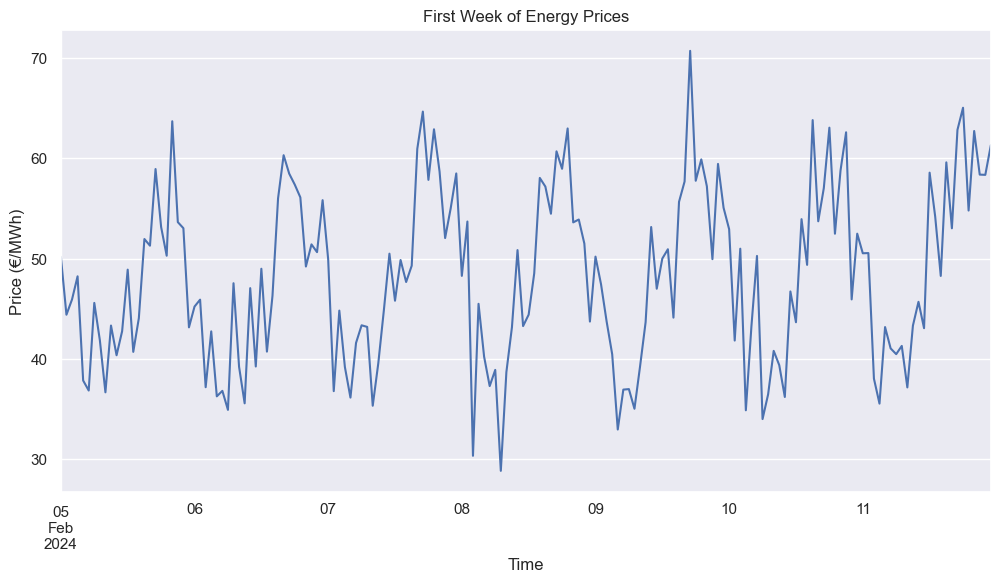

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sys
import os

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_theme()

# Add the project root directory to the Python path
sys.path.append(os.path.abspath('..'))

# Import our synthetic data generator
from synthetic_data import generate_synthetic_data

# Generate synthetic data for one year
end = pd.Timestamp.now(tz='Europe/Amsterdam')
start = end - pd.Timedelta(days=365)

df = generate_synthetic_data(
    start_date=start.strftime('%Y-%m-%d'),
    end_date=end.strftime('%Y-%m-%d')
)

# Save raw data
os.makedirs('../data', exist_ok=True)
df.to_csv('../data/raw_prices.csv')

# Display basic statistics
print("Data shape:", df.shape)
print("\nBasic statistics:")
print(df.describe())

# Plot the first week of data
plt.figure(figsize=(12, 6))
df['price'].head(24*7).plot()
plt.title('First Week of Energy Prices')
plt.xlabel('Time')
plt.ylabel('Price (€/MWh)')
plt.grid(True)
plt.show()

Feature DataFrame shape: (8593, 16)

Features created:
- price
- hour
- dayofweek
- quarter
- month
- year
- dayofyear
- hour_sin
- hour_cos
- price_lag24
- price_lag48
- price_lag168
- rolling_mean_24h
- rolling_mean_7d
- rolling_std_24h
- rolling_std_7d


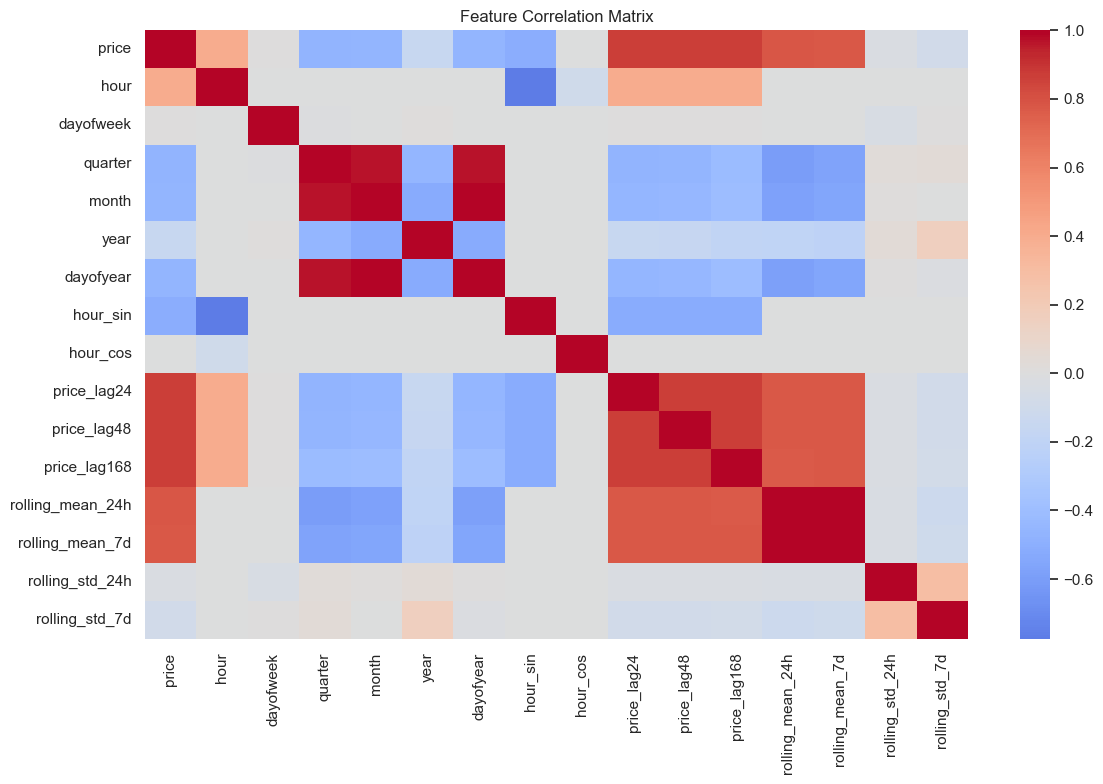

In [3]:
# Feature Engineering
def create_features(df):
    """
    Create time-based features for our model.
    """
    df = df.copy()
    
    # Time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    
    # Cyclical features for hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    
    # Lag features (24 hours, 48 hours, and 1 week)
    df['price_lag24'] = df['price'].shift(24)
    df['price_lag48'] = df['price'].shift(48)
    df['price_lag168'] = df['price'].shift(168)
    
    # Rolling mean features
    df['rolling_mean_24h'] = df['price'].rolling(window=24).mean()
    df['rolling_mean_7d'] = df['price'].rolling(window=168).mean()
    
    # Rolling std features
    df['rolling_std_24h'] = df['price'].rolling(window=24).std()
    df['rolling_std_7d'] = df['price'].rolling(window=168).std()
    
    return df

# Create features
df_features = create_features(df)

# Remove rows with NaN values (due to lag features)
df_features = df_features.dropna()

# Display the first few rows of our features
print("Feature DataFrame shape:", df_features.shape)
print("\nFeatures created:")
for col in df_features.columns:
    print(f"- {col}")

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_features.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

Model Performance Metrics:
Mean Squared Error: 25.47
Mean Absolute Error: 3.99
R² Score: 0.87


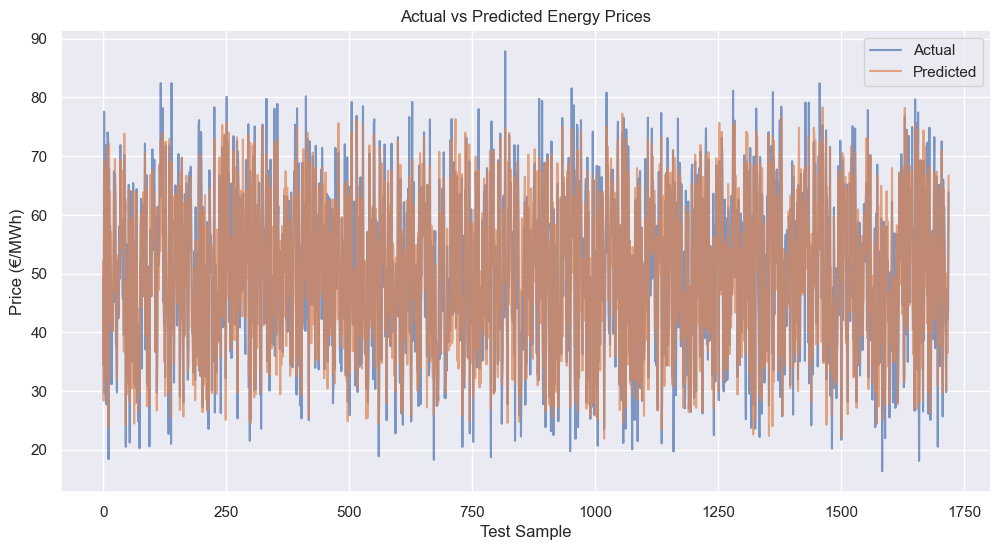

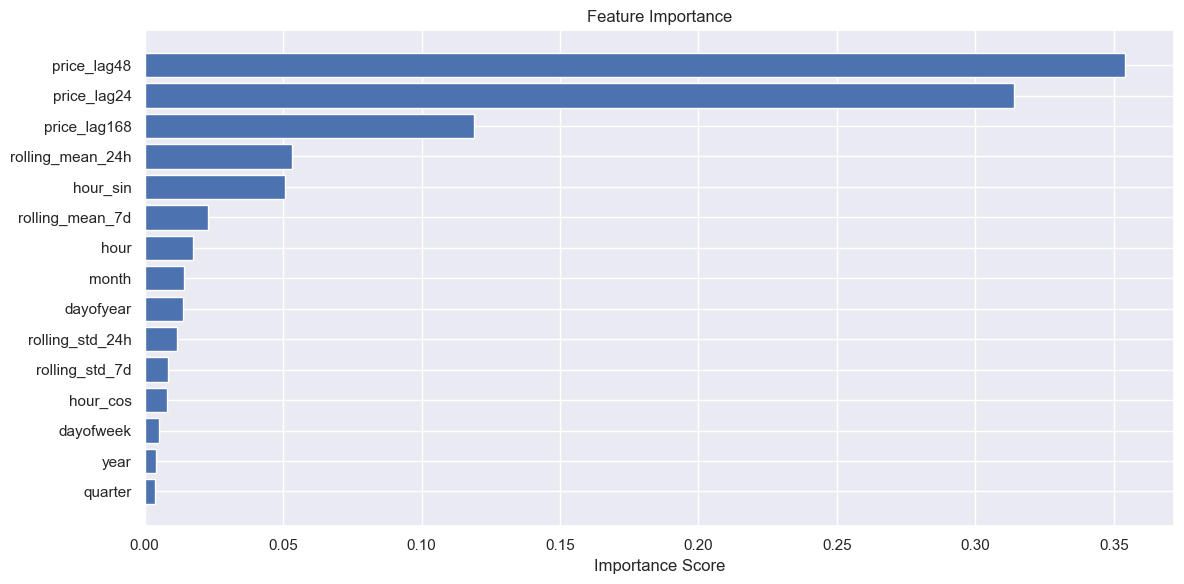

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Prepare features and target
feature_columns = [col for col in df_features.columns if col != 'price']
X = df_features[feature_columns]
y = df_features['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train XGBoost model
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
test_indices = range(len(y_test))
plt.plot(test_indices, y_test.values, label='Actual', alpha=0.7)
plt.plot(test_indices, y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Energy Prices')
plt.xlabel('Test Sample')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance plot
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=True)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


/var/folders/b9/s_8_7fd16bq9hcqzmjjvwmdw0000gr/T/ipykernel_20195/1289258600.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_mae = df_test.groupby('hour').apply(lambda x: mean_absolute_error(x['actual'], x['predicted']))
/var/folders/b9/s_8_7fd16bq9hcqzmjjvwmdw0000gr/T/ipykernel_20195/1289258600.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_mape = df_test.groupby('hour').apply(lambd

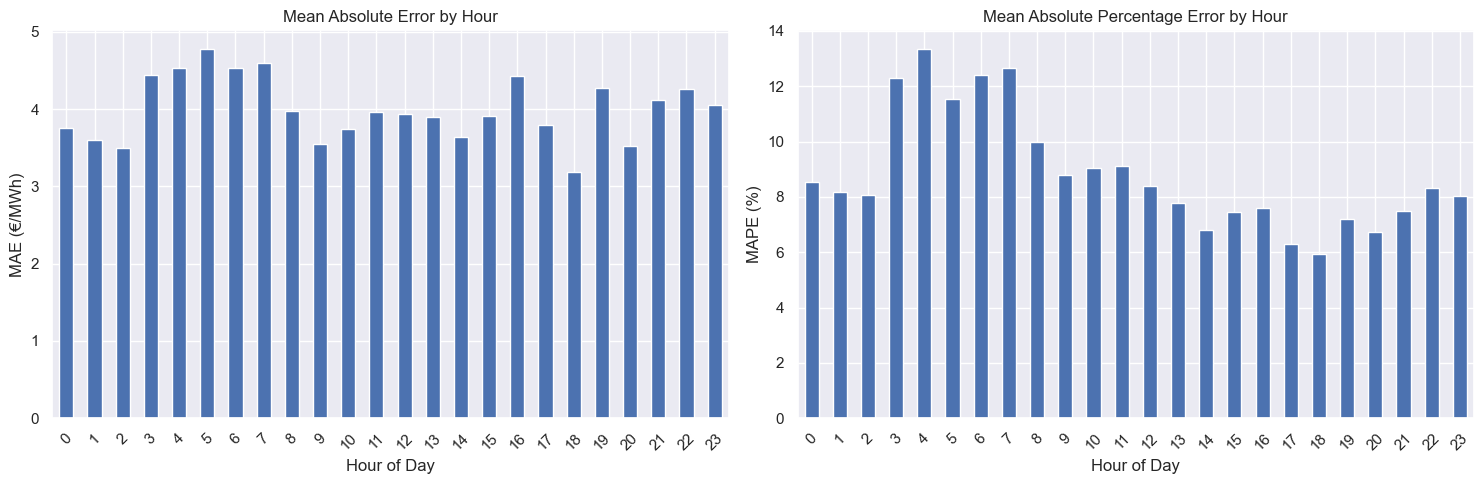

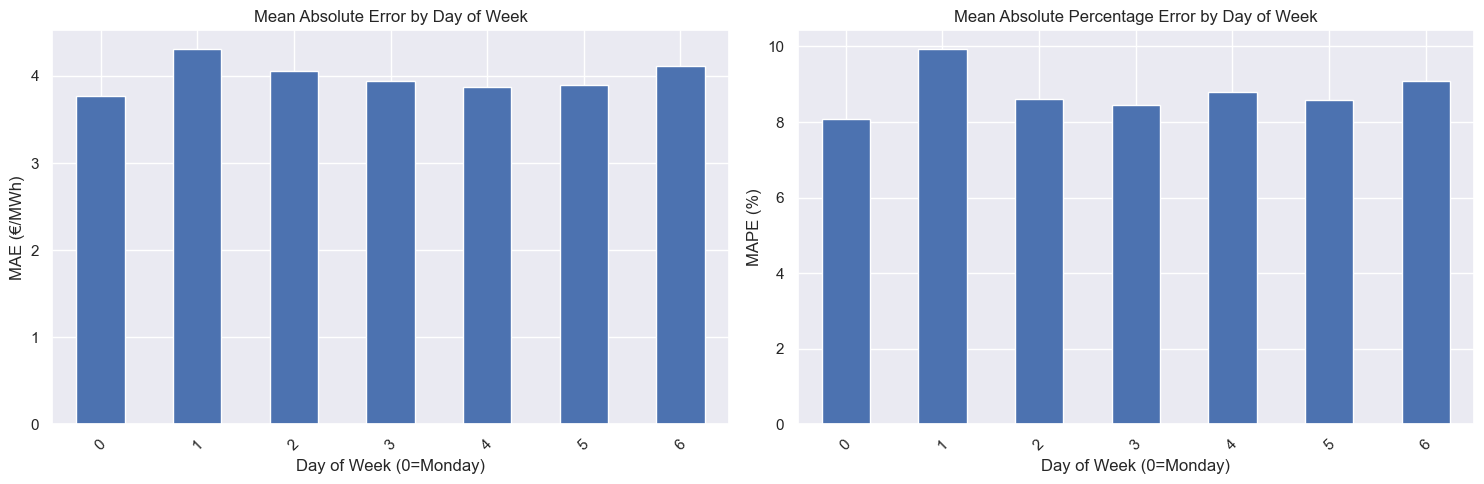


Hourly Performance Summary:
Best performing hours (lowest MAE):
hour
18    3.189175
2     3.498935
20    3.521588
dtype: float64

Worst performing hours (highest MAE):
hour
5    4.779306
7    4.602819
4    4.537395
dtype: float64

Daily Performance Summary:
Best performing days (lowest MAE):
dayofweek
0    3.771400
4    3.878299
5    3.893016
dtype: float64

Worst performing days (highest MAE):
dayofweek
1    4.307921
6    4.108912
2    4.051508
dtype: float64


In [7]:
# Calculate hourly and daily performance
df_test = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'hour': X_test['hour'],
    'dayofweek': X_test['dayofweek']
})

# Hourly analysis
hourly_mae = df_test.groupby('hour').apply(lambda x: mean_absolute_error(x['actual'], x['predicted']))
hourly_mape = df_test.groupby('hour').apply(lambda x: np.mean(np.abs((x['actual'] - x['predicted']) / x['actual'])) * 100)

# Daily analysis
daily_mae = df_test.groupby('dayofweek').apply(lambda x: mean_absolute_error(x['actual'], x['predicted']))
daily_mape = df_test.groupby('dayofweek').apply(lambda x: np.mean(np.abs((x['actual'] - x['predicted']) / x['actual'])) * 100)

# Plot hourly performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

hourly_mae.plot(kind='bar', ax=ax1)
ax1.set_title('Mean Absolute Error by Hour')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('MAE (€/MWh)')
ax1.tick_params(axis='x', rotation=45)

hourly_mape.plot(kind='bar', ax=ax2)
ax2.set_title('Mean Absolute Percentage Error by Hour')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('MAPE (%)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plot daily performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

daily_mae.plot(kind='bar', ax=ax1)
ax1.set_title('Mean Absolute Error by Day of Week')
ax1.set_xlabel('Day of Week (0=Monday)')
ax1.set_ylabel('MAE (€/MWh)')
ax1.tick_params(axis='x', rotation=45)

daily_mape.plot(kind='bar', ax=ax2)
ax2.set_title('Mean Absolute Percentage Error by Day of Week')
ax2.set_xlabel('Day of Week (0=Monday)')
ax2.set_ylabel('MAPE (%)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nHourly Performance Summary:")
print("Best performing hours (lowest MAE):")
print(hourly_mae.nsmallest(3))
print("\nWorst performing hours (highest MAE):")
print(hourly_mae.nlargest(3))

print("\nDaily Performance Summary:")
print("Best performing days (lowest MAE):")
print(daily_mae.nsmallest(3))
print("\nWorst performing days (highest MAE):")
print(daily_mae.nlargest(3))

Advanced Model Performance Metrics:
Mean Squared Error: 0.19
Mean Absolute Error: 0.29
R² Score: 1.00


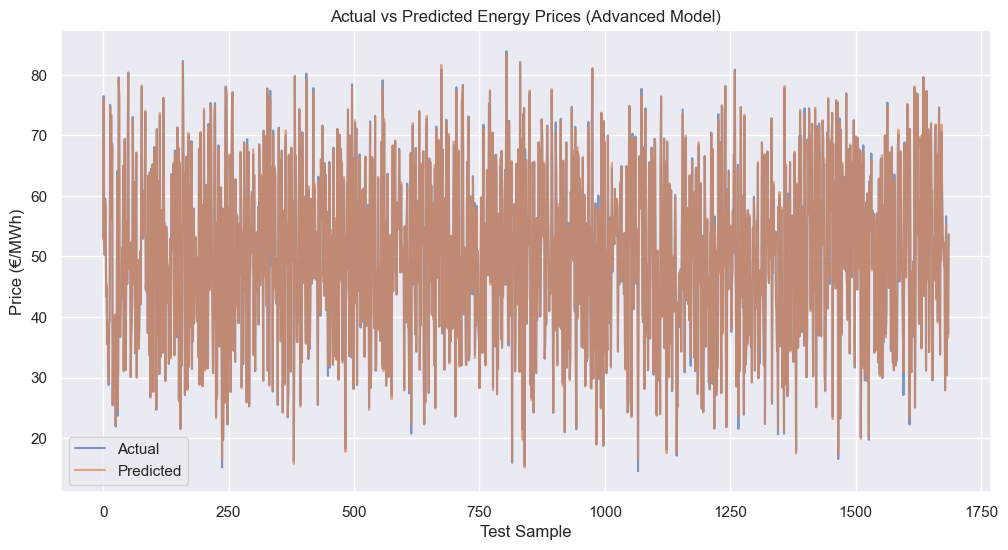

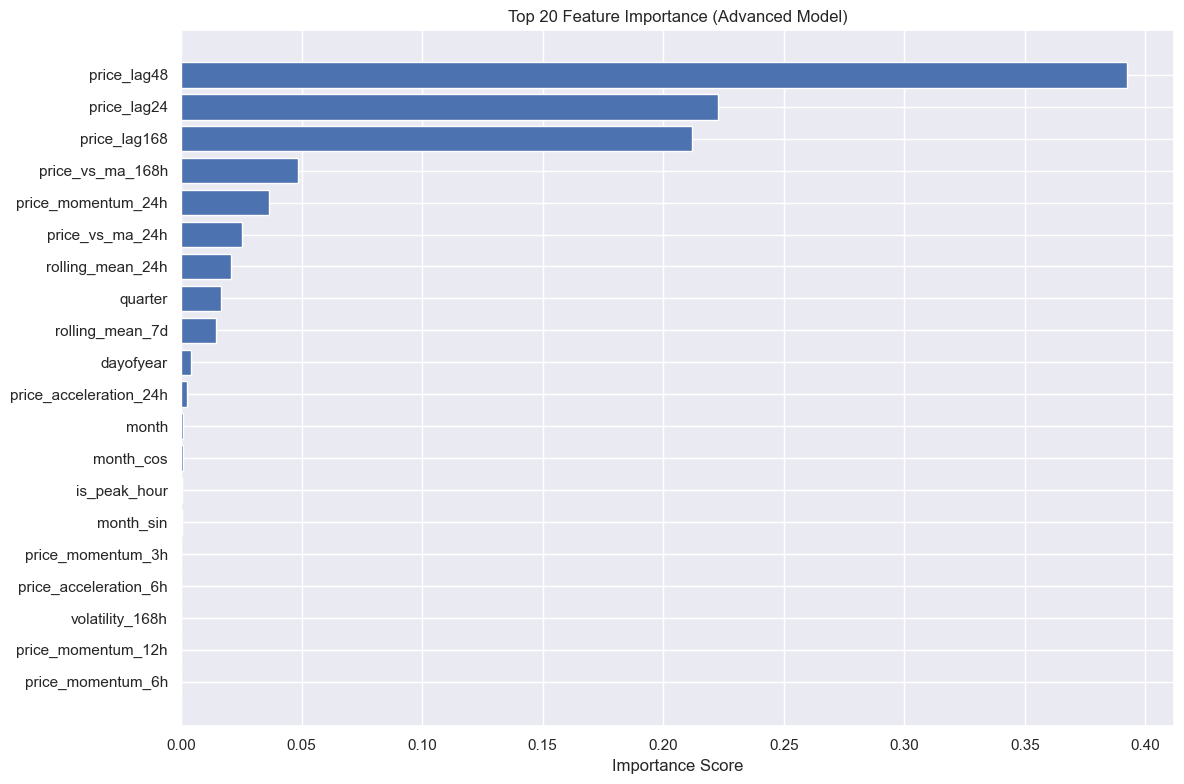


Top 10 Most Important Features:
               feature  importance
9          price_lag48    0.392276
8          price_lag24    0.222529
10        price_lag168    0.212136
34    price_vs_ma_168h    0.048572
27  price_momentum_24h    0.036513
33     price_vs_ma_24h    0.025094
11    rolling_mean_24h    0.020875
2              quarter    0.016674
12     rolling_mean_7d    0.014464
5            dayofyear    0.004215


In [9]:
# Enhanced feature engineering
def create_advanced_features(df):
    df = df.copy()
    
    # Peak hours flag (7-23)
    df['is_peak_hour'] = (df['hour'].between(7, 22)).astype(int)
    
    # Weekend flag
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # More sophisticated cyclical features
    for period, max_val in [('hour', 24), ('dayofweek', 7), ('month', 12)]:
        df[f'{period}_sin'] = np.sin(2 * np.pi * df[period]/max_val)
        df[f'{period}_cos'] = np.cos(2 * np.pi * df[period]/max_val)
    
    # Price momentum features
    for window in [3, 6, 12, 24]:
        df[f'price_momentum_{window}h'] = df['price'].diff(window) / window
        df[f'price_acceleration_{window}h'] = df[f'price_momentum_{window}h'].diff()
    
    # Volatility features
    for window in [24, 168]:  # 24h and 1 week
        df[f'volatility_{window}h'] = df['price'].rolling(window).std()
        df[f'range_{window}h'] = df['price'].rolling(window).max() - df['price'].rolling(window).min()
        
    # Price relative to moving averages
    for window in [24, 168]:
        ma = df['price'].rolling(window).mean()
        df[f'price_vs_ma_{window}h'] = df['price'] / ma - 1
    
    return df

# Create enhanced features
df_advanced = create_advanced_features(df_features)
df_advanced = df_advanced.dropna()  # Remove NaN values from rolling calculations

# Prepare features and target
feature_columns = [col for col in df_advanced.columns if col != 'price']
X = df_advanced[feature_columns]
y = df_advanced['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define improved XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 200,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': 42
}

# Train improved model
model_advanced = xgb.XGBRegressor(**xgb_params)
model_advanced.fit(X_train, y_train)

# Make predictions
y_pred_advanced = model_advanced.predict(X_test)

# Calculate metrics
mse_advanced = mean_squared_error(y_test, y_pred_advanced)
mae_advanced = mean_absolute_error(y_test, y_pred_advanced)
r2_advanced = r2_score(y_test, y_pred_advanced)

print("Advanced Model Performance Metrics:")
print(f"Mean Squared Error: {mse_advanced:.2f}")
print(f"Mean Absolute Error: {mae_advanced:.2f}")
print(f"R² Score: {r2_advanced:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
test_indices = range(len(y_test))
plt.plot(test_indices, y_test.values, label='Actual', alpha=0.7)
plt.plot(test_indices, y_pred_advanced, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Energy Prices (Advanced Model)')
plt.xlabel('Test Sample')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

# Plot top 20 feature importances
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model_advanced.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=True).tail(20)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Top 20 Feature Importance (Advanced Model)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Print feature importance summary
print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))